<h1 style="font-size:35px;
        color:black;
        ">Sheet 11</h1>

<h4 style="font-size: 17px">&#128211;Part 1. Variational Quantum Eigensolver </h4>

To parametrize a real two-qubit state we need 3 angles. To prepare the ansatz we can use the circuit shown in class.

In [34]:
from qiskit import *
from qiskit_aer import Aer
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RYGate
from qiskit.quantum_info.operators import Operator
from IPython.display import display, Math, Latex
import numpy as np
import matplotlib.pyplot as plt

In [35]:
def prepare_ansatz():
    
    ansatz = QuantumCircuit(2)
    theta = ParameterVector('theta', length=3)
    
    ansatz.ry(theta[0], 0)
    antiCRY = RYGate(theta[1]).control(num_ctrl_qubits=1, ctrl_state='0')
    ansatz.append(antiCRY, [0,1])
    CRY = RYGate(theta[2]).control(num_ctrl_qubits=1, ctrl_state='1')
    ansatz.append(CRY, [0,1])
    
    return ansatz

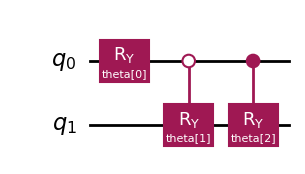

In [36]:
ansatz = prepare_ansatz()
display(ansatz.draw('mpl'))

The decomposition of such state in terms of the angles is
$$|\Psi\rangle = \cos\left(\frac{\theta_0}{2}\right) \cos\left(\frac{\theta_1}{2}\right) |00\rangle + \cos\left(\frac{\theta_0}{2}\right) \sin\left(\frac{\theta_1}{2}\right) |10\rangle + \sin\left(\frac{\theta_0}{2}\right) \cos\left(\frac{\theta_2}{2}\right) |01\rangle + \sin\left(\frac{\theta_0}{2}\right) \sin\left(\frac{\theta_2}{2}\right) |11\rangle 
$$

In [37]:
def measure_energy(angles=None, state=None):
    """Inputs| state: QuantumCircuit, angles: array of floats
    Computes The expectation value of the Hydrogen Hamiltonian w.r.t. state psi(angles)
    """
    if state is None:
        psi = prepare_ansatz()
        
        if angles is not None:
            state = psi.assign_parameters(angles, inplace=False)
        else:
            state = psi.copy()
     
    U = QuantumCircuit(2)
    U.cx(0,1)
    U.h(0)
    U.measure_all()
    
    shots = 10000 # number of samples used for statistics
    simulator = Aer.get_backend('aer_simulator')
    
    # run the circuit and get the number of samples that output each bit value
    circ_trans = transpile(state.compose(U), simulator)
    counts = simulator.run(circ_trans, shots=shots).result().get_counts()
    # calculate the probabilities for each bit value
    probs = {}
    for output in ['00','01','10','11']:
        if output in counts:
            probs[output] = counts[output]/shots
        else:
            probs[output] = 0
            
    expect_val = []
    #compute <XX>, <YY> and <ZZ> in diagonal form
    #<XX_diag>
    expect_val.append(probs['00'] - probs['01'] + probs['10'] - probs['11']) 
    #<YY_diag>
    expect_val.append(-probs['00'] + probs['01'] + probs['10'] - probs['11']) 
    #<ZZ_diag>
    expect_val.append(probs['00'] + probs['01'] - probs['10'] - probs['11']) 

    return np.sum(expect_val)

Let's start by rewriting the expectation values of the individual terms in the Hamiltonian in terms of the angles in the parametrical wavefunction:
$$\langle\hat{X}\hat{X}\rangle_{\overrightarrow{\theta}} = \sin(\theta_0)\sin\left(\frac{\theta_1+\theta_2}{2}\right)$$
$$\langle\hat{Y}\hat{Y}\rangle_{\overrightarrow{\theta}} = \cos(\theta_0)\sin\left(\frac{\theta_1-\theta_2}{2}\right)$$
$$\langle\hat{Z}\hat{Z}\rangle_{\overrightarrow{\theta}} = \frac{\cos\theta_0+1}{2}\cos(\theta_1) - \frac{\cos\theta_0-1}{2}\cos(\theta_2)$$

To show that the gradients can be determined via a finite-difference method, we can then derivate w.r.t. one of the angles, such as
$$\frac{\partial\langle\hat{X}\hat{X}\rangle}{\partial\theta_0} = \cos(\theta_0)\sin\left(\frac{\theta_1+\theta_2}{2}\right) = \frac{1}{2}\left[\sin\left(\theta_0+\frac{\pi}{2}\right)-\sin\left(\theta_0-\frac{\pi}{2}\right)\right]\sin\left(\frac{\theta_1+\theta_2}{2}\right) = \frac{1}{2}\left(\langle\hat{X}\hat{X}\rangle_{\theta_0+\frac{\pi}{2}} - \langle\hat{X}\hat{X}\rangle_{\theta_0-\frac{\pi}{2}}\right)$$
Notice that the necessary shift is not always going to be $\frac{\pi}{2}$, for example
$$\frac{\partial\langle\hat{X}\hat{X}\rangle}{\partial\theta_1} = \frac{1}{2}\sin(\theta_0)\cos\left(\frac{\theta_1+\theta_2}{2}\right) = \frac{1}{4}\sin\theta_0\left[\sin\left(\frac{\theta_1+\theta_2}{2}+\frac{\pi}{2}\right)-\sin\left(\frac{\theta_1+\theta_2}{2}-\frac{\pi}{2}\right)\right] = \frac{1}{4}\left(\langle\hat{X}\hat{X}\rangle_{\theta_1+\pi} - \langle\hat{X}\hat{X}\rangle_{\theta_1-\pi}\right)$$
The other 7 equations can be similarly derived to find
$$\frac{\partial\langle\hat{X}\hat{X}\rangle}{\partial\theta_0} = \frac{1}{2}\left(\langle\hat{X}\hat{X}\rangle_{\theta_0+\frac{\pi}{2}} - \langle\hat{X}\hat{X}\rangle_{\theta_0-\frac{\pi}{2}}\right), \qquad
\frac{\partial\langle\hat{X}\hat{X}\rangle}{\partial\theta_{1,2}} = \frac{1}{4}\left(\langle\hat{X}\hat{X}\rangle_{\theta_{1,2}+\pi} - \langle\hat{X}\hat{X}\rangle_{\theta_{1,2}-\pi}\right)\\ \frac{\partial\langle\hat{Y}\hat{Y}\rangle}{\partial\theta_0} = \frac{1}{2}\left(\langle\hat{Y}\hat{Y}\rangle_{\theta_0+\frac{\pi}{2}} - \langle\hat{Y}\hat{Y}\rangle_{\theta_0-\frac{\pi}{2}}\right), \qquad
\frac{\partial\langle\hat{Y}\hat{Y}\rangle}{\partial\theta_{1,2}} = \frac{1}{4}\left(\langle\hat{Y}\hat{Y}\rangle_{\theta_{1,2}+\pi} - \langle\hat{Y}\hat{Y}\rangle_{\theta_{1,2}-\pi}\right) \\
\frac{\partial\langle\hat{Z}\hat{Z}\rangle}{\partial\theta_{0,1,2}} = \frac{1}{2}\left(\langle\hat{Z}\hat{Z}\rangle_{\theta_{0,1,2}+\frac{\pi}{2}} - \langle\hat{Z}\hat{Z}\rangle_{\theta_{0,1,2}-\frac{\pi}{2}}\right)$$
To estimate different increments in the parameter, we need to redefine out energy measurement so that we can evaluate $\langle\hat{X}\hat{X}\rangle$, $\langle\hat{Y}\hat{Y}\rangle$ and $\langle\hat{Z}\hat{Z}\rangle$ separately.

In [38]:
def measure_XX(angles=None, state=None):
    """Inputs| state: QuantumCircuit, angles: array of floats
    Computes The expectation value of the Hydrogen Hamiltonian w.r.t. state psi(angles)
    """
    if state is None:
        psi = prepare_ansatz()
        
        if angles is not None:
            state = psi.assign_parameters(angles, inplace=False)
        else:
            state = psi.copy()
     
    U = QuantumCircuit(2)
    U.cx(0,1)
    U.h(0)
    U.measure_all()
    
    shots = 10000 # number of samples used for statistics
    simulator = Aer.get_backend('aer_simulator')
    
    # run the circuit and get the number of samples that output each bit value
    circ_trans = transpile(state.compose(U), simulator)
    counts = simulator.run(circ_trans, shots=shots).result().get_counts()
    # calculate the probabilities for each bit value
    probs = {}
    for output in ['00','01','10','11']:
        if output in counts:
            probs[output] = counts[output]/shots
        else:
            probs[output] = 0

    #compute <XX> in diagonal form
    #<XX_diag>
    expect_val = probs['00'] - probs['01'] + probs['10'] - probs['11']

    return expect_val

In [39]:
def measure_YY(angles=None, state=None):
    """Inputs| state: QuantumCircuit, angles: array of floats
    Computes The expectation value of the Hydrogen Hamiltonian w.r.t. state psi(angles)
    """
    if state is None:
        psi = prepare_ansatz()
        
        if angles is not None:
            state = psi.assign_parameters(angles, inplace=False)
        else:
            state = psi.copy()
     
    U = QuantumCircuit(2)
    U.cx(0,1)
    U.h(0)
    U.measure_all()
    
    shots = 10000 # number of samples used for statistics
    simulator = Aer.get_backend('aer_simulator')
    
    # run the circuit and get the number of samples that output each bit value
    circ_trans = transpile(state.compose(U), simulator)
    counts = simulator.run(circ_trans, shots=shots).result().get_counts()
    # calculate the probabilities for each bit value
    probs = {}
    for output in ['00','01','10','11']:
        if output in counts:
            probs[output] = counts[output]/shots
        else:
            probs[output] = 0

    #compute <YY> 
    #<YY_diag>
    expect_val = -probs['00'] + probs['01'] + probs['10'] - probs['11']

    return expect_val

In [40]:
def measure_ZZ(angles=None, state=None):
    """Inputs| state: QuantumCircuit, angles: array of floats
    Computes The expectation value of the Hydrogen Hamiltonian w.r.t. state psi(angles)
    """
    if state is None:
        psi = prepare_ansatz()
        
        if angles is not None:
            state = psi.assign_parameters(angles, inplace=False)
        else:
            state = psi.copy()
     
    U = QuantumCircuit(2)
    U.cx(0,1)
    U.h(0)
    U.measure_all()
    
    shots = 10000 # number of samples used for statistics
    simulator = Aer.get_backend('aer_simulator')
    
    # run the circuit and get the number of samples that output each bit value
    circ_trans = transpile(state.compose(U), simulator)
    counts = simulator.run(circ_trans, shots=shots).result().get_counts()
    # calculate the probabilities for each bit value
    probs = {}
    for output in ['00','01','10','11']:
        if output in counts:
            probs[output] = counts[output]/shots
        else:
            probs[output] = 0

    #compute <ZZ> in diagonal form
    #<ZZ_diag>
    expect_val = probs['00'] + probs['01'] - probs['10'] - probs['11']

    return expect_val

In [41]:
def gradient(theta):
        
        dH_0 = 1/2*(measure_energy(angles=[theta[0]+np.pi/2, theta[1], theta[2]]) - measure_energy(angles=[theta[0]-np.pi/2, theta[1], theta[2]]))
        dH_1 = 1/4*(measure_XX(angles=[theta[0], theta[1]+np.pi, theta[2]]) - measure_XX(angles=[theta[0], theta[1]-np.pi, theta[2]])) \
                +1/4*(measure_YY(angles=[theta[0], theta[1]+np.pi, theta[2]]) - measure_YY(angles=[theta[0], theta[1]-np.pi, theta[2]]))\
                +1/2*(measure_ZZ(angles=[theta[0], theta[1]+np.pi/2, theta[2]]) - measure_ZZ(angles=[theta[0], theta[1]-np.pi/2, theta[2]]))
        dH_2 = 1/4*(measure_XX(angles=[theta[0], theta[1], theta[2]+np.pi]) - measure_XX(angles=[theta[0], theta[1], theta[2]-np.pi])) \
                +1/4*(measure_YY(angles=[theta[0], theta[1], theta[2]+np.pi]) - measure_YY(angles=[theta[0], theta[1], theta[2]-np.pi]))\
                +1/2*(measure_ZZ(angles=[theta[0], theta[1], theta[2]+np.pi/2]) - measure_ZZ(angles=[theta[0], theta[1], theta[2]-np.pi/2]))
        
        return np.array([dH_0, dH_1, dH_2])
    
    
    
    
def gradient_descent(initial_point):
    
    
    theta = initial_point
    iterations = 50 #number of iterations after which check for convergence
    eta = 1e-1
    initial_value = measure_energy(angles=initial_point)
    old_value = initial_value   
    converged = False
    i = 0
    
    while not converged:
        grad = gradient(theta)
        theta = theta - eta * grad
        new_value = measure_energy(angles=theta)
        
        if i>iterations and abs(new_value-old_value) < 1e-7:
            converged = True
            
        old_value = new_value
        i += 1
        
            
    return theta, old_value

In [42]:
initial_point = np.zeros(3)
optimized_angles, optimized_energy = gradient_descent(initial_point)
print('The minimal energy reached by the VQE algorithm is {} with angles {}'.format(optimized_energy, optimized_angles))

The minimal energy reached by the VQE algorithm is -2.9992 with angles [-1.574700e+00  3.106695e+00  2.295000e-03]


In [43]:
ground_state = ansatz.assign_parameters(optimized_angles, inplace=False)

simulator = Aer.get_backend('statevector_simulator')

circ_trans = transpile(ground_state, simulator)
result = simulator.run(circ_trans, shots=1e4).result()
statevector = result.get_statevector()

print('The ground state found with the VQE is ')
display(Math(statevector.draw(output='latex_source')))

The ground state found with the VQE is 


<IPython.core.display.Math object>

<h4 style="font-size: 17px">&#128211;Comparison with scipy minimizer </h4>

In [44]:
from scipy.optimize import minimize

initial_point = np.zeros(3)
solution_scipy = minimize(measure_energy, initial_point, method='COBYLA', tol=1e-6)
optimized_angles_scipy = solution_scipy.x
optimized_energy_scipy = solution_scipy.fun
print('The minimal energy reached with scipy is {} with angles {}'.format(optimized_energy_scipy, optimized_angles_scipy))

The minimal energy reached with scipy is -3.0 with angles [ 1.55985588 -3.11499498 -0.00532666]


In [45]:
ground_state_scipy = ansatz.assign_parameters(optimized_angles_scipy, inplace=False)

simulator = Aer.get_backend('statevector_simulator')

circ_trans = transpile(ground_state_scipy, simulator)
result = simulator.run(circ_trans, shots=1e4).result()
statevector = result.get_statevector()

print('The ground state found with scipy is ')
display(Math(statevector.draw(output='latex_source')))

The ground state found with scipy is 


<IPython.core.display.Math object>